En este cuaderno se utilizará el modelo generado, para realizar las predicciones sobre la clase test, y mostrarlas para verificar su correcto funcionamiento.

Importamos todas las librerías y creamos las rutas que se utilizarán.

In [9]:
import torch
from PIL import Image
from torchvision.transforms import functional as F
import torch.nn.functional as F_nn
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

from train import get_model_instance_segmentation

import os
import cv2
import matplotlib.pyplot as plt

CWD = os.getcwd()
PATH_CITYSCAPE_DATA = os.path.join(CWD, 'datasets/cityscape_data')
PATH_MODEL = os.path.join(CWD, "final_model/maskrcnn_cityscapes.pth")
PATH_IMAGES = os.path.join(CWD, "display_elements/car_segmentation/images")
PATH_VIDEOS = os.path.join(CWD, "display_elements/car_segmentation/videos")
PATH_RESULT_IMAGES = os.path.join(CWD, "results/car_segmentation/images")
PATH_RESULT_VIDEOS = os.path.join(CWD, "results/car_segmentation/videos")

try:
    os.mkdir(PATH_RESULT_IMAGES)
    os.mkdir(PATH_RESULT_VIDEOS)
except FileExistsError:
    pass

print(f"Dataset: {PATH_CITYSCAPE_DATA}")
print(f"Models: {PATH_MODEL}")
print(f"Images: {PATH_IMAGES}")
print(f"Videos: {PATH_VIDEOS}")
print(f"Resulting images: {PATH_RESULT_IMAGES}")
print(f"Resulting videos: {PATH_RESULT_VIDEOS}")

Dataset: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\datasets/cityscape_data
Models: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\final_model/maskrcnn_cityscapes.pth
Images: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\display_elements/car_segmentation/images
Videos: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\display_elements/car_segmentation/videos
Resulting images: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\results/car_segmentation/images
Resulting videos: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-predic

# INSTANCIACIÓN DE VEHÍCULOS

## Cargar el modelo

Primero, debemos cargar el modelo entrenado con el fine-tunning, para realizar las predicciones.

In [10]:
# Set the acceleration device (or the CPU if cuda is not available)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Get the model pre-trained model
num_classes = 8
model = get_model_instance_segmentation(8)

# Load the calculated weights in fine-tunning process
data_model = torch.load(PATH_MODEL, map_location=device, weights_only=False)
model.load_state_dict(data_model['model_state_dict'])

# Move the model to the acceleration device and set the model into evaluation mode
model.to(device)
model.eval() 

print("Loaded model and ready to inference.")

Loaded model and ready to inference.


## Predicción en imagen

A continuación, se define una función que, dada una imagen, dibuja sobre ella las máscaras de segmentación y las bounding boxes etiquetadas con la clase que el modelo a asignado a esa instancia

In [11]:
def draw_predictions(image_tensor, pred_masks, pred_boxes, pred_labels, masks_colors=None, custom_labels=False):
    """
        This method draw over a given image the segmentation masks and bounding boxes of given predictions
    Args:
        image_tensor: the image in Tensor format
        pred_masks: The segmentation masks
        pred_boxes: The bounding boxes
        pred_labels: The labels for each predicted class
        masks_colors: The array with the color of each mask
        custom_lables: If True, then the label within the box will be exactly as in pred_labels. 
                       If False, then will be in format "Class: label".


    Returns:
        processed_image: the image with masks and bounding boxes drawn on it
    """

    # DRAW MASKS
    image_int = (image_tensor * 255).to(torch.uint8)

    # if there are no elements detected, returns the original image
    if len(pred_boxes) == 0:
        return image_int.permute(1, 2, 0).cpu().numpy()

    # Get only the vehicles in the masks
    masks_bool = pred_masks > 0.5
    masks_bool = masks_bool.squeeze(1) 

    # Draw the masks
    if len(masks_bool) > 0:
        if masks_colors is not None:
            processed_image = draw_segmentation_masks(image_int, masks_bool, alpha=0.6, colors=masks_colors)
        else:
            processed_image = draw_segmentation_masks(image_int, masks_bool, alpha=0.6, colors="green")
    else:
        processed_image = image_int

    # Draw the bounding boxes
    if len(pred_boxes) > 0:
        if not custom_labels:
            pred_labels = [f"Class: {label}" for label in pred_labels]
        
        processed_image = draw_bounding_boxes(
            processed_image, 
            pred_boxes, 
            labels=pred_labels, 
            colors="yellow", 
            width=3
        )

    processed_image = processed_image.permute(1, 2, 0).cpu().numpy()
    return processed_image

Ahora, se define una función que devuelve las predicciones del modelo, sobre una imagen

In [12]:
def get_predictions(image_tensor, model, img_h, img_w, score_threshold=0.5, max_height=0):
    """
        This method calculates the predictions of the car segmentation model of a given image,
        and returns the predictions with a confidence level above a given threshold
    Args:
        image: The image to be processed
        model: The model that computes the predictions
        img_h, img_w: The dimensions of the image.
        score_threshold: The confidence threshold
        max_height: The row from which the model evaluates the image. 0 means no cropping (slower), 
                    1 means cropping whole image (no image processed). Default 0 to no cropping.

    Returns:
        pred_masks: The segmentation masks
        pred_boxes: The bounding boxes
        pred_labels: The labels for each predicted class
    """
    
    # Check that max_height is not to low (minimum computes 40% of the image)
    if 0 < max_height < 0.6*img_h:
        input_tensor = image_tensor[:, max_height:, :]
    else:
        input_tensor = image_tensor

    # Turn off gradient mode during the prediction execution
    with torch.no_grad():
        predictions = model([input_tensor])

    prediction = predictions[0]

    # Only keep predictions if the model has a certain level of confidence about them (over 50% score)
    keep_idx = prediction['scores'] > score_threshold

    # If nothing detected, we return the original image
    if not keep_idx.any():
        empty_box = torch.empty((0, 4), device=image_tensor.device)
        empty_mask = torch.empty((0, 1, image_tensor.shape[1], image_tensor.shape[2]), device=image_tensor.device)
        empty_label = torch.empty((0), dtype=torch.int64, device=image_tensor.device)
        return empty_mask, empty_box, empty_label

    pred_boxes = prediction['boxes'][keep_idx]
    pred_masks = prediction['masks'][keep_idx]
    pred_labels = prediction['labels'][keep_idx]

    # Adjust coordinates if image cropped
    if 0 < max_height < 0.6*img_h:
        pred_boxes[:, [1, 3]] += max_height
        full_masks = torch.zeros((len(pred_masks), 1, img_h, img_w), device=image_tensor.device)
        full_masks[:, :, max_height:, :] = pred_masks
        return full_masks, pred_boxes, pred_labels

    return pred_masks, pred_boxes, pred_labels

Ahora, se va a definir una función que realice el proceso de calcular las predicciones de un modelo de segmentación de vehículos sobre de una imagen, y devuelva la imagen con las predicciones dibujadas sobre ella.

In [13]:
def segmentate_vehicles(image, model, device='cpu'):
    # Convert the image to Tensor format
    image_tensor = F.to_tensor(image).to(device)
    _, img_h, img_w = image_tensor.shape

    pred_masks, pred_boxes, pred_labels = get_predictions(image_tensor, model, img_h, img_w, 0.5)
    image_processed = draw_predictions(image_tensor, pred_masks, pred_boxes, pred_labels)

    return image_processed
    

Ahora, se va a mostrar el resultado de procesar una imagen tomada del famoso videojuego GTA V.

Saving image to: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\results/car_segmentation/images\gta8_result.png
Image saved correctly


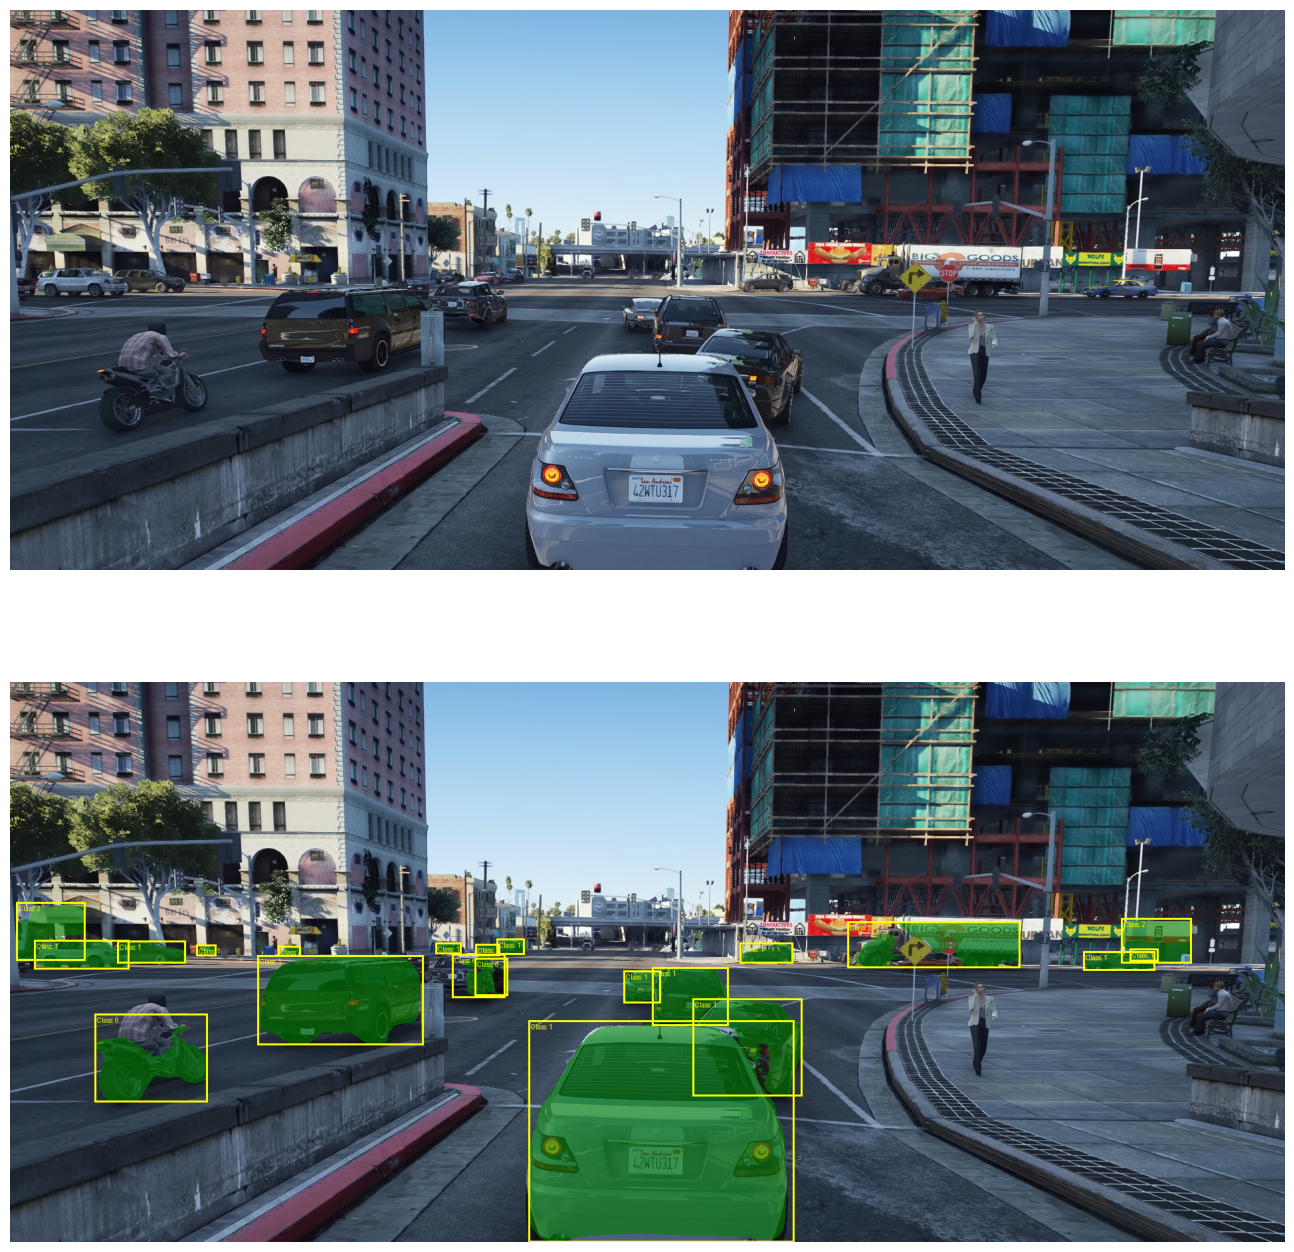

In [14]:
# Get the image
image_name = "gta8.png"
img_path = os.path.join(PATH_IMAGES, image_name)
img_result_path = os.path.join(PATH_RESULT_IMAGES, os.path.splitext(image_name)[0] + '_result.png')

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_processed = segmentate_vehicles(image, model, device)

# Save the processed image in the results directory
output_bgr = cv2.cvtColor(image_processed, cv2.COLOR_RGB2BGR)
print(f"Saving image to: {img_result_path}")
resultado = cv2.imwrite(img_result_path, output_bgr)

if resultado:
    print("Image saved correctly")
else:
    print("An error ocurred while saving the image")

# Show the results
plt.figure(figsize=(24, 16))
plt.subplot(2,1,1)
plt.imshow(image)
plt.axis('off')
plt.subplot(2,1,2)
plt.imshow(image_processed)
plt.axis('off')
plt.show()

# "car":        1, (0, 0, 142)
# "truck":      2, (0, 0, 70)
# "bus":        3, (0, 60, 100)
# "caravan":    4, (0, 0, 90)
# "trailer":    5, (0, 0, 110)
# "motorcycle": 6, (0, 0, 230)
# "bicycle":    7, (119, 11, 32)

Se puede observar que, pese a que comete algunos errores con los objetos a gran distancia. El modelo detecta y clasifica, perfectamente todos los vehículos de la imagen. En especial del entorno cercano, que es el que más preocupa en el problema del cáclulo de la distancia

## Predicción en vídeo

Ya se ha demostrado el funcionamiento del modelo en imágenes. Ahora se procede a calcular las predicciones para una secuencia de vídeo entera.

In [ ]:
def process_segmentation_video(video_path, output_path, model, device='cpu', score_threshold=0.5, frames_per_prediction=1, show=False):
    """
        This functions processes a video by calculating the model predictions and draw them on the video

    Args:
        video_path: The path to the video file
        output_path: The path where the resulting video is written
        model: The segmentation model that predicts masks and bouding boxes
        device: The device where the computations will be done. CPU by default
        score_threshold: The asurance of the model for shwoing the instance predictions 
        frames_per_prediction: The amount of frames that passes beetwen each prediction. The smaller, the faster the process, but results will be worst. Default is 1 (every frame)
        show: If True, then the video is displayed while computing.

    Returns:
        true if video is correctly processed, False if an error ocurred.
    """
    # Control frames per second
    if frames_per_prediction <= 0:
        print("Frmes per predictions must be > 0\n")
        return False

    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        return False
    else:
        # Create Writer with same properties that the original video
        img_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        img_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
        out = cv2.VideoWriter(output_path, fourcc, fps, (img_w, img_h))
        
        print(f"Processing video... Resolution: {img_w}x{img_h}, FPS: {fps}")
        
        frame_count = 0

        prev_max_height = 0     # First process the whole image
        RESET_MAX_HEIGHT = 25   # Each 25 frames, model predicts the whole image

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break # Video ended

            # Convert the image to Tensor format
            frame_tensor = F.to_tensor(frame).to(device)
            
            # Let between model predictions as many frames as the parameter frames_per_prediction
            if frame_count % frames_per_prediction == 0:

                # Each certain amount of frames, processes the whole image
                if frame_count % RESET_MAX_HEIGHT == 0:
                    prev_max_height = 0

                # Process the frame and write it in the ouput route
                pred_masks, pred_boxes, pred_labels = get_predictions(frame_tensor, model, 
                                                                      img_h, img_w, 
                                                                      score_threshold,
                                                                      prev_max_height
                                                                      )
                
                # Update the maximum height reached by any bounding box
                if len(pred_boxes) > 0:
                    prev_max_height = int(torch.min(pred_boxes[:, 1]).item()) - int(img_h*0.1)   # margin of 10% above the maximum bounding box height                

            frame_processed = draw_predictions(frame_tensor, pred_masks, pred_boxes, pred_labels)
            out.write(frame_processed)
            
            # Show the frame processing in real time
            if show:
                cv2.imshow("Processed video", frame_processed)
            
            frame_count += 1
            if frame_count % 50 == 0:
                print(f"{frame_count} frames processed...")

            # Exit if press 'q'
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        # Free resources
        cap.release()
        out.release()
        cv2.destroyAllWindows()
        return True

Finalmente, se procede a mostrar el resultado de aplicar el procesado, a un video de conducción por Los Ángeles. Se despliega también una ventana donde se puede ver el procesado de cada frame a tiempo real

In [16]:
# Get the video capture
video_name = "video2"
video_path = os.path.join(PATH_VIDEOS, f"{video_name}.mp4")
output_path = os.path.join(PATH_RESULT_VIDEOS,f"{video_name}_result.mp4")

result = process_segmentation_video(video_path, output_path, model, device, score_threshold=0.7, frames_per_prediction=3, show=False)

if result:
    print(f"Video saved in: {output_path}")
else:
    print("An error ocurred while openning the video.")

Processing video... Resolution: 1560x720, FPS: 24.001465738365702
50 frames processed...
100 frames processed...
150 frames processed...
200 frames processed...
250 frames processed...
300 frames processed...
350 frames processed...
Video saved in: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\results/car_segmentation/videos\video2_result.mp4
